# Usage Examples for `QuadratiK` in Python
Authors : Giovanni Saraceno, Marianthi Markatou, Raktim Mukhopadhyay, Mojgan Golzy

Date : 4 June 2024

In [1]:
%matplotlib inline

In [2]:
# please feel free to chanege the default renderer, for options see: https://plotly.com/python/renderers/
import plotly.io as pio
pio.renderers.default = "png"

## Introduction

This document contains various Python examples illustrating the use of `QuadratiK`

### Installation

The python package QuadratiK and other necessary packages must be installed. 

## Normality Test

We illustrate the usage of the introduced KernelTest for the Normality
test. We generate one sample from a multivariate standard Normal distribution, that is $x = (x_1, . . . , x_n)$ ∼
$N_d(0, I_d)$ with dimension $d = 4$, and sample size $n = 500$.

In [3]:
import numpy as np

np.random.seed(78990)
from QuadratiK.kernel_test import KernelTest

# data generation
data_norm = np.random.multivariate_normal(mean=np.zeros(4), cov=np.eye(4), size=500)

# performing the normality test
normality_test = KernelTest(
    h=0.4, num_iter=150, method="subsampling", random_state=42
).test(data_norm)

# printing the summary for normality test
print(normality_test.summary())

Time taken for execution: 3.278 seconds
Test Results 
Kernel-based quadratic distance Normality test 
                                        U-Statistic    V-Statistic
------------------------------------  -------------  -------------
Test Statistic                            -0.114594       0.977955
Critical Value                             1.15931       42.46
H0 is rejected (1 = True, 0 = False)       0              0
CV method: None 
Selected tuning parameter h : 0.4 

Summary Statistics 
           Feature 0    Feature 1    Feature 2    Feature 3
-------  -----------  -----------  -----------  -----------
Mean         -0.0148      -0.0253       0.0376      -0.0232
Std Dev       1.0053       1.0201       0.9796       1.0197
Median       -0.001        0.0439       0.0846      -0.0404
IQR           1.3786       1.3761       1.2441       1.3611
Min          -3.7131      -3.2847      -2.7106      -3.6615
Max           2.8297       2.6076       2.784        3.0463


## K-Sample Test

We generate three samples, with $n=200$ observations each, from a 2-dimensional Gaussian distributions with mean vectors $\mu_1 = (0, \sqrt(3)/3)$, $\mu_2 = (-1/2, -\sqrt(3)/6)$ and  $\mu_3 = (1/2, \sqrt(3)/6)$, and the Identity matrix as Covariance matrix.  

In [4]:
import numpy as np

np.random.seed(0)
from QuadratiK.kernel_test import KernelTest

size = 200
eps = 1
x1 = np.random.multivariate_normal(
    mean=[0, np.sqrt(3) * eps / 3], cov=np.eye(2), size=size
)
x2 = np.random.multivariate_normal(
    mean=[-eps / 2, -np.sqrt(3) * eps / 6], cov=np.eye(2), size=size
)
x3 = np.random.multivariate_normal(
    mean=[eps / 2, -np.sqrt(3) * eps / 6], cov=np.eye(2), size=size
)
# Merge the three samples into a single dataset
X_k = np.concatenate([x1, x2, x3])
# The memberships are needed for k-sample test
y_k = np.repeat(np.array([1, 2, 3]), size).reshape(-1, 1)

# performing the k-sample test
k_sample_test = KernelTest(h=1.5, method="subsampling", random_state=42).test(X_k, y_k)

# printing the summary for the k-sample test
print(k_sample_test.summary())

Time taken for execution: 0.438 seconds
Test Results 
Kernel-based quadratic distance K-sample test 
                                             Dn     Trace
------------------------------------  ---------  --------
Test Statistic                        13.8947    52.736
Critical Value                         0.325527   1.23574
H0 is rejected (1 = True, 0 = False)   1          1
CV method: subsampling 
Selected tuning parameter h : 1.5 

Summary Statistics 
                            Group 1    Group 2    Group 3    Overall
------------------------  ---------  ---------  ---------  ---------
('Feature 0', 'Mean')       -0.072     -0.6075     0.6442    -0.0117
('Feature 0', 'Std Dev')     0.9983     0.9833     0.9378     1.099
('Feature 0', 'Median')     -0.1255    -0.6203     0.6998    -0.0332
('Feature 0', 'IQR')         1.3818     1.3067     1.2031     1.4906
('Feature 0', 'Min')        -2.6592    -2.8696    -2.0828    -2.8696
('Feature 0', 'Max')         2.3831     2.1962     3.67

## Two-Sample Test


This example shows the application of the two-sample test. 
Instead of providing the vector of membership to the two groups as for the 
k-sample test, the two-sample test can be additionally performed by providing 
the two samples to be compared. We generate the sample $y_1, ..., y_n$ from a 
skew-normal distribution $SN_d(0,I_d, \lambda)$, where $d=4$, $n=200$ and 
$\lambda = (0.5, ..., 0.5)$. 

**Note:** If a value of `h` is not provided, the `select_h` function can be used to determine the optimal `h`. Please see examples below where `select_h` function has been illustrated. 

In [5]:
import numpy as np

np.random.seed(0)
from scipy.stats import skewnorm

from QuadratiK.kernel_test import KernelTest

# data generation
X_2 = np.random.multivariate_normal(mean=np.zeros(4), cov=np.eye(4), size=200)
Y_2 = skewnorm.rvs(
    size=(200, 4),
    loc=np.zeros(4),
    scale=np.ones(4),
    a=np.repeat(0.5, 4),
    random_state=20,
)
# performing the two sample test
two_sample_test = KernelTest(h=2, num_iter=150, random_state=42).test(X_2, Y_2)

# printing the summary for the two sample test
print(two_sample_test.summary())

Time taken for execution: 0.236 seconds
Test Results 
Kernel-based quadratic distance two-sample test 
                                            Dn     Trace
------------------------------------  --------  --------
Test Statistic                        5.06121   15.7517
Critical Value                        0.490116   1.52578
H0 is rejected (1 = True, 0 = False)  1          1
CV method: subsampling 
Selected tuning parameter h : 2 

Summary Statistics 
                            Group 1    Group 2    Overall
------------------------  ---------  ---------  ---------
('Feature 0', 'Mean')       -0.1158     0.3704     0.1273
('Feature 0', 'Std Dev')     1.0236     0.9005     0.9931
('Feature 0', 'Median')     -0.2211     0.3726     0.1151
('Feature 0', 'IQR')         1.4552     1.1904     1.3979
('Feature 0', 'Min')        -2.553     -2.2457    -2.553
('Feature 0', 'Max')         2.3831     2.2507     2.3831
('Feature 1', 'Mean')       -0.1468     0.3715     0.1123
('Feature 1', 'Std D

The `qq_plot` function can be used to generate the qq-plots between the given samples. 

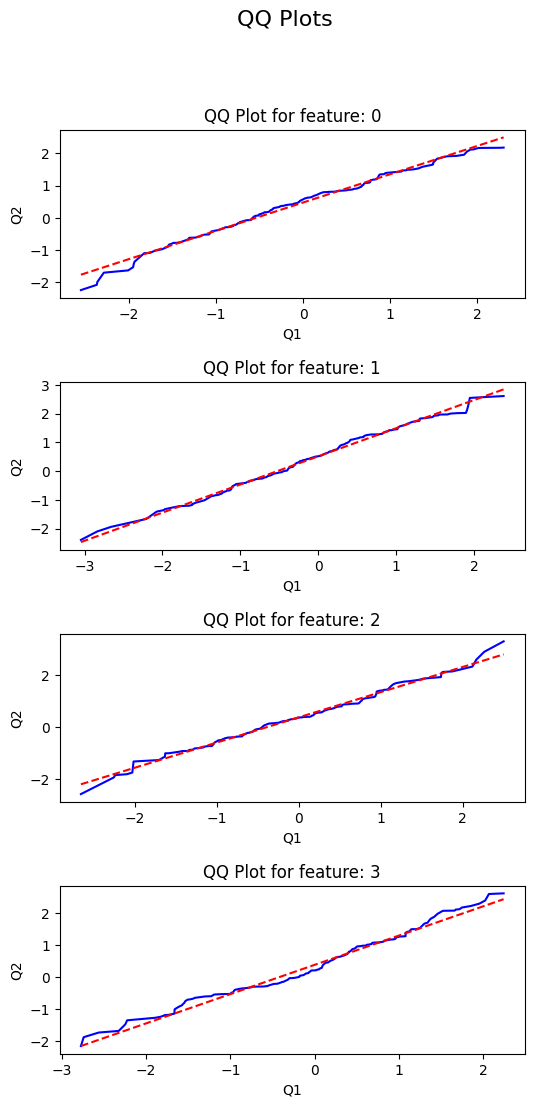

In [6]:
from QuadratiK.tools import qq_plot

qq_plot(X_2, Y_2)

## Uniformity Test

We generate $n=200$ observations from the uniform distribution 
on $S^{d-1}$, with $d=3$.  

In [7]:
import numpy as np

np.random.seed(0)
from QuadratiK.poisson_kernel_test import PoissonKernelTest

# data generation
z = np.random.normal(size=(200, 3))
data_unif = z / np.sqrt(np.sum(z**2, axis=1, keepdims=True))

# performing the uniformity test
unif_test = PoissonKernelTest(rho=0.7, random_state=42).test(data_unif)

# printing the summary for uniformity test
print(unif_test.summary())

Time taken for execution: 0.076 seconds
Test Results 
Poisson Kernel-based quadratic distance test of Uniformity on the Sphere 
                                        U-Statistic    V-Statistic
------------------------------------  -------------  -------------
Test Statistic                             0.597782        19.7226
Critical Value                             1.61281         23.2295
H0 is rejected (1 = True, 0 = False)       0                0
Concentration parameter rho: 0.7

Summary Statistics 
           Feature 0    Feature 1    Feature 2
-------  -----------  -----------  -----------
Mean          0.011       -0.0275      -0.1068
Std Dev       0.5931       0.5788       0.553
Median        0.013       -0.0448      -0.1833
IQR           1.0685       0.9798       0.9148
Min          -0.9836      -0.9766      -0.9938
Max           0.9819       0.9975       0.9862


The `qq_plot` function can be used to generate the qq-plots between the given samples and the uniform distribution.

## Tuning Parameter $h$ selection

The algorithm is implemented through the function `select_h`. 
The function select_h takes as arguments the data matrix x, the vector of 
labels y, and the type of alternatives (one of "location", "scale" or 
"skewness");  select_h returns not only the selected value of h, but also the 
power plot versus the considered list of h values for each tested value of 
$\delta$. 

### For Two-Sample Test

We present the algorithm for selecting the optimal value of the tuning 
parameter in the two-sample problem. 
The algorithm for the selection of h for 
the two-sample test can be also performed providing the two samples $x$ 
and $y$.

In [8]:
from QuadratiK.kernel_test import select_h

# Perform the algorithm for selecting h
h_selected, all_powers, plot = select_h(
    x=X_2, y=Y_2, alternative="location", power_plot=True
)
print(f"Selected h is: {h_selected}")

Selected h is: 0.8


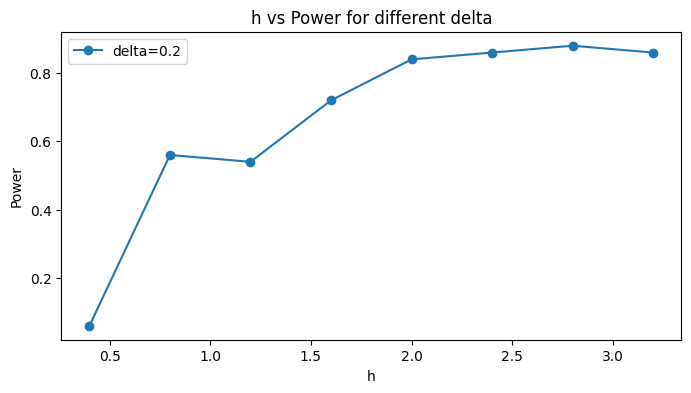

In [9]:
plot

### For K-Sample Test

We present the algorithm for selecting the optimal value of the tuning parameter in the k-sample problem. 

In [10]:
from QuadratiK.kernel_test import select_h

# Perform the algorithm for selecting h
h_selected, all_powers, plot = select_h(
    x=X_k, y=y_k, alternative="skewness", power_plot=True, method="subsampling", b=0.2
)
print(f"Selected h is: {h_selected}")

Selected h is: 1.2


## Real World Examples

### Two-Sample Test

We utilize the Wisconsin Breast Cancer (Diagnostic) Dataset from the UCI repository to demonstrate the application of the Two-Sample Test in a real-world context.

In [11]:
from QuadratiK.datasets import load_wisconsin_breast_cancer_data
from QuadratiK.kernel_test import KernelTest, select_h

X, y = load_wisconsin_breast_cancer_data(return_X_y=True, scaled=True)

# Create masks for Malignant (M) and Benign (B) tumors
malignant_mask = y == 1
benign_mask = y == 0

# Create X1 and X2 using the masks
X1 = X[malignant_mask.all(axis=1)]
X2 = X[benign_mask.all(axis=1)]

# Perform the algorithm for selecting h
h_selected, all_powers = select_h(
    x=X1, y=X2, alternative="skewness", method="subsampling", b=0.5, n_jobs=-1
)
print(f"Selected h is: {h_selected}")

# performing the two sample test
two_sample_test = KernelTest(h=h_selected, num_iter=150, random_state=42).test(X1, X2)

# printing two sample test object
print(two_sample_test)

Selected h is: 0.4
KernelTest(
  Test Type=Kernel-based quadratic distance two-sample test,
  Execution Time=0.44962000846862793 seconds,
  Dn-Statistic=11.576053314243081,
  Dn-Statistic Critical Value=0.10192401996447628,
  Dn-Statistic Null Hypothesis Rejected=True,
  Dn-Statistic Variance=2.1204435325619427e-05,
  Trace-Statistic=103.19086054532785,
  Trace-Statistic Critical Value=0.8992234767524736,
  Trace-Statistic Null Hypothesis Rejected=True,
  Trace-Statistic Variance=7.588559074989729e-08,
  Selected tuning parameter h=0.4,
  Critical Value Method=subsampling
)


### K-Sample Test

To illustrate the application of the K-Sample Test, we use the wine dataset from the UCI repository.

In [12]:
from QuadratiK.datasets import load_wine_data
from QuadratiK.kernel_test import KernelTest, select_h

X, y = load_wine_data(return_X_y=True, scaled=True)

# Perform the algorithm for selecting h
h_selected, all_powers = select_h(
    x=X, y=y, alternative="skewness", n_jobs=-1, b=0.5, method="subsampling"
)
print(f"Selected h is: {h_selected}")

# performing the two sample test
k_sample_test = KernelTest(h=h_selected, num_iter=150, random_state=42).test(X, y)

# printing the summary for the two sample test
print(k_sample_test.summary())

Selected h is: 2.8
Time taken for execution: 0.104 seconds
Test Results 
Kernel-based quadratic distance K-sample test 
                                            Dn     Trace
------------------------------------  --------  --------
Test Statistic                        7.77916   37.8734
Critical Value                        0.383583   1.88836
H0 is rejected (1 = True, 0 = False)  1          1
CV method: subsampling 
Selected tuning parameter h : 2.8 

Summary Statistics 
                             Group 1    Group 2    Group 3    Overall
-------------------------  ---------  ---------  ---------  ---------
('Feature 0', 'Mean')         0.0127     0.0251     0.0213     0.02
('Feature 0', 'Std Dev')      0.0025     0.0069     0.004      0.0073
('Feature 0', 'Median')       0.0126     0.0248     0.0211     0.019
('Feature 0', 'IQR')          0.0031     0.011      0.0051     0.0112
('Feature 0', 'Min')          0.0084     0.0131     0.0141     0.0084
('Feature 0', 'Max')          0.019

### Poisson Kernel Based Clustering

We consider the Wireless Indoor Localization Data Set, publicly available in the UCI Machine Learning Repository’s website. This data set is used to study the performance of different indoor localization algorithms. 

The Wireless Indoor Localization data set contains the measurements of the Wi-Fi signal strength in different indoor rooms. It consists of a data frame with 2000 rows and 8 columns. The first 7 variables report the values of the Wi-Fi signal strength received from 7 different Wi-Fi routers in an office location in Pittsburgh (USA). The last column indicates the class labels, from 1 to 4, indicating the different rooms. Notice that, the Wi-Fi signal strength is measured in dBm, decibel milliwatts, which is expressed as a negative value ranging from -100 to 0. In total, we have 500 observations for each room.

Given that the Wi-Fi signal strength takes values in a limited range, it is appropriate to consider the spherically transformed observations, by $L_2$ normalization, and consequently perform the clustering algorithm on the 7-dimensional sphere.



In [13]:
import warnings

from QuadratiK.datasets import load_wireless_data
from QuadratiK.spherical_clustering import PKBC

warnings.filterwarnings("ignore")

X, y = load_wireless_data(return_X_y=True)
# number of clusters tried are from 2 to 10
pkbc = PKBC(num_clust=range(2, 11), random_state=42).fit(X)

In [14]:
validation_metrics, elbow_plots = pkbc.validation(y_true=y)

To guide the choice of the number of clusters, the function validation provides cluster validation measures and graphical tools. Specifically, it displays the Elbow plot from the computed within-cluster sum of squares values and returns an a table of computed evaluation measures as shown below. 

In [15]:
print(validation_metrics.round(2))

                             2     3     4     5     6     7     8     9    10
Metrics                                                                       
ARI                       0.31  0.70  0.94  0.91  0.88  0.80  0.73  0.69  0.60
Macro Precision           0.31  0.61  0.98  0.98  0.98  0.98  0.97  0.98  0.97
Macro Recall              0.50  0.75  0.98  0.98  0.98  0.98  0.97  0.98  0.97
Average Silhouette Score  0.42  0.35  0.38  0.30  0.20  0.13  0.11  0.08  0.10


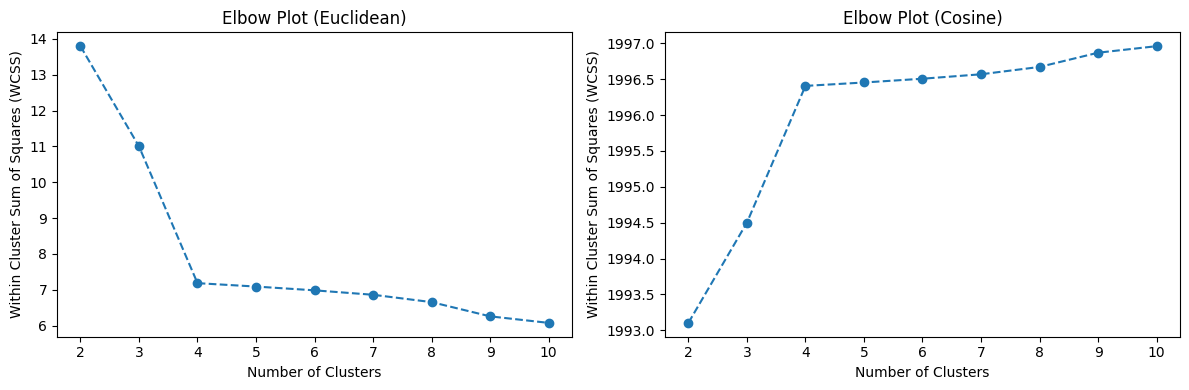

In [16]:
elbow_plots

In [17]:
print(pkbc.summary())

      Loglikelihood    Euclidean WCSS    Cosine WCSS  Num Data Point/Cluster                                                          Mixing Proportions (alpha)
--  ---------------  ----------------  -------------  ------------------------------------------------------------------------------  ---------------------------------------------------
 2          18954.2             13.8         1993.1   {0: 1458, 1: 542}                                                               [0.73 0.27]
 3          21249.9             11           1994.5   {0: 522, 1: 974, 2: 504}                                                        [0.27 0.47 0.25]
 4          22325.2              7.19        1996.41  {2: 504, 3: 510, 1: 486, 0: 500}                                                [0.25 0.24 0.26 0.26]
 5          22444.7              7.09        1996.45  {1: 507, 4: 460, 3: 487, 0: 46, 2: 500}                                         [0.03 0.26 0.25 0.24 0.23]
 6          22596.6              6.99  

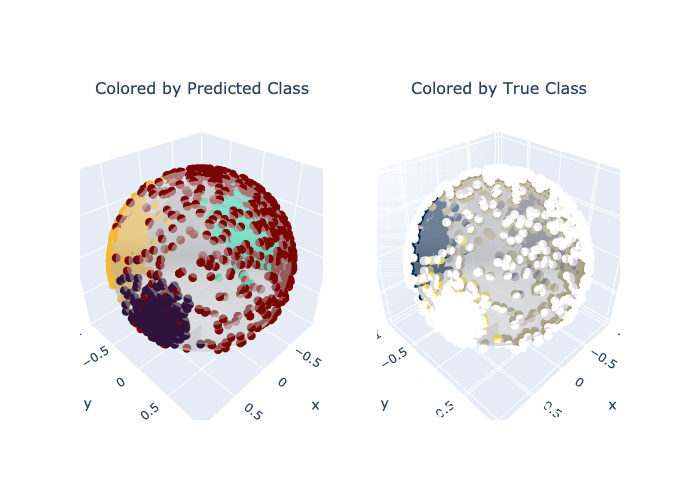

In [18]:
pkbc.plot(num_clust=4, y_true=y)

The clusters identified with $k=4$ achieve high performance in terms of ARI, Macro Precision and Macro Recall.

## Initializing the Dashboard

We show the initialization of the dashboard application. The corresponding code snippet is given below.

In [19]:
# uncomment the below code to instantiate the dashboard on a local machine
"""
from QuadratiK.ui import UI
UI().run()
"""

'\nfrom QuadratiK.ui import UI\nUI().run()\n'

![Dashboard](images/dash-landing.png)

The above image shows the landing page of the user interface in the `QuadratiK` package